# Longitudinal data analysis - Regularization

Our method can be tuned to the data by a contiues parameter $\lambda$, which controls the penalty on the dimensionality of the solution. Our implementation has a built-in cross-validation parametrized with the following variables:

- `lambda` values of $\lambda$ that you want to test,
- `cv.ratio` test/train ratio that you want to use for validation,
- `folds` number of validation rounds.

In this vignette, we illustrate how to use this internal cross-validation process and how to analyze results.

## Preparing the `bones` dataset for the analysis

As in the introduction vignette, we will be using the data from the study of Bachrach et al. (1999), where they analyze spinal bone minaral density of patients. We load this data from the [*Elements of statistical learning*](https://web.stanford.edu/~hastie/ElemStatLearn/) book.

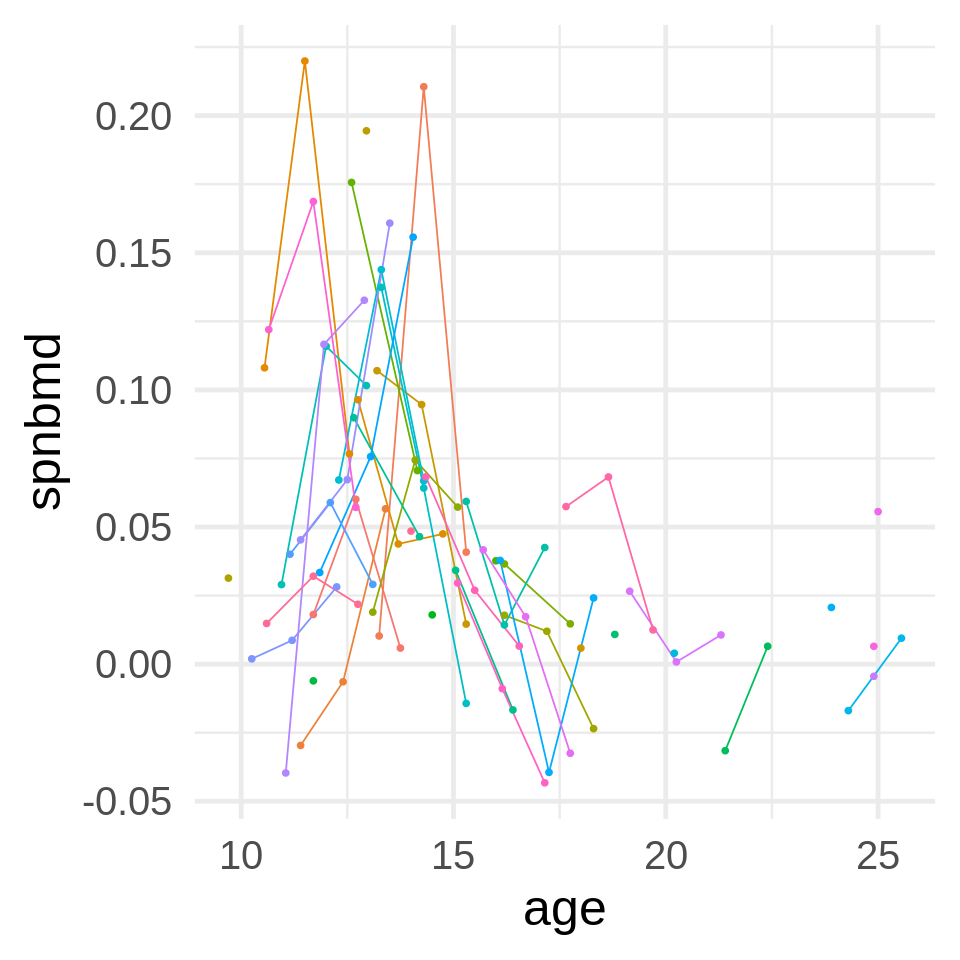

In [15]:
library("fcomplete")

options(repr.plot.width=8, repr.plot.height=8)
theme_set(theme_minimal(base_size = 30)) # for presentation clarity

ggplot(aes(x = age, y = spnbmd, color = factor(idnum)), data = bone[1:100,]) +
    geom_line() + geom_point() + theme(legend.position="none")

Next, we run the optimization using some grid of `lambda`s, with a test set size set to $20\%$ using parameter `cv.ratio`, and with `3` repetitions with parameter `fold`. 

In [26]:
# Train both models on the training set
fit.fimpute.train = fregression(spnbmd ~ age | idnum, data = bone, d = 6, K = 3,
                                lambda=0:10/200, cv.ratio=0.2, fold=3, verbose = 0)
print(fit.fimpute.train)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


fcomplete fitted using the 'fimpute' method with a formula: ~spnbmdage | idnum
  Number of fitted subjects (N):	 261
  Number of evaluation timpoints:	 51
  Maximum dimension (K):		 3
  Observed to N*K ratio:		 0.6194125
  Estimated r-squared:			 0.8932877

We analyze results of the cross-validation by looking into the `meta` table of the model object

In [22]:
fit.fimpute.train$meta

lambda,cv.K,cv.err,fit.err
<dbl>,<dbl>,<dbl>,<dbl>
0.0000,3,0.04204254,0.002899497
0.0025,3,0.03592179,0.014243500
0.0050,2,0.03367957,0.016796180
0.0075,2,0.03244211,0.018766879
0.0100,2,0.03170707,0.020736344
0.0125,2,0.03130822,0.022551908
0.0150,2,0.03116750,0.024302308
0.0175,2,0.03121287,0.025955095
0.0200,2,0.03137508,0.027506099


Here, the `lambda` corresponds to the $\lambda$ used for cross-validation. `cv.K` is the chosen dimension, `cv.err` is the cross-validation error (measured as a mean squared error of prediction on the points chosen for test), while `fit.err` is the mean squared error of the model on the training set.

Note that the training set error increases with $\lambda$. This is to be expected since $\lambda$ constrains the model until the point where a zero-dimensional model is chosen ($K=0$) and no variance is explained. 

Meanwhlie, the cross-validation error exhibits a different pattern -- first we see a big drop of the error and then it goes up again. Choosing the right $\lambda$ leads to the good prediction. In the next section, we further tune this parameter.

## Choosing the best `lambda` using cross-validation

Let's start with plotting the results of the cross-validation.

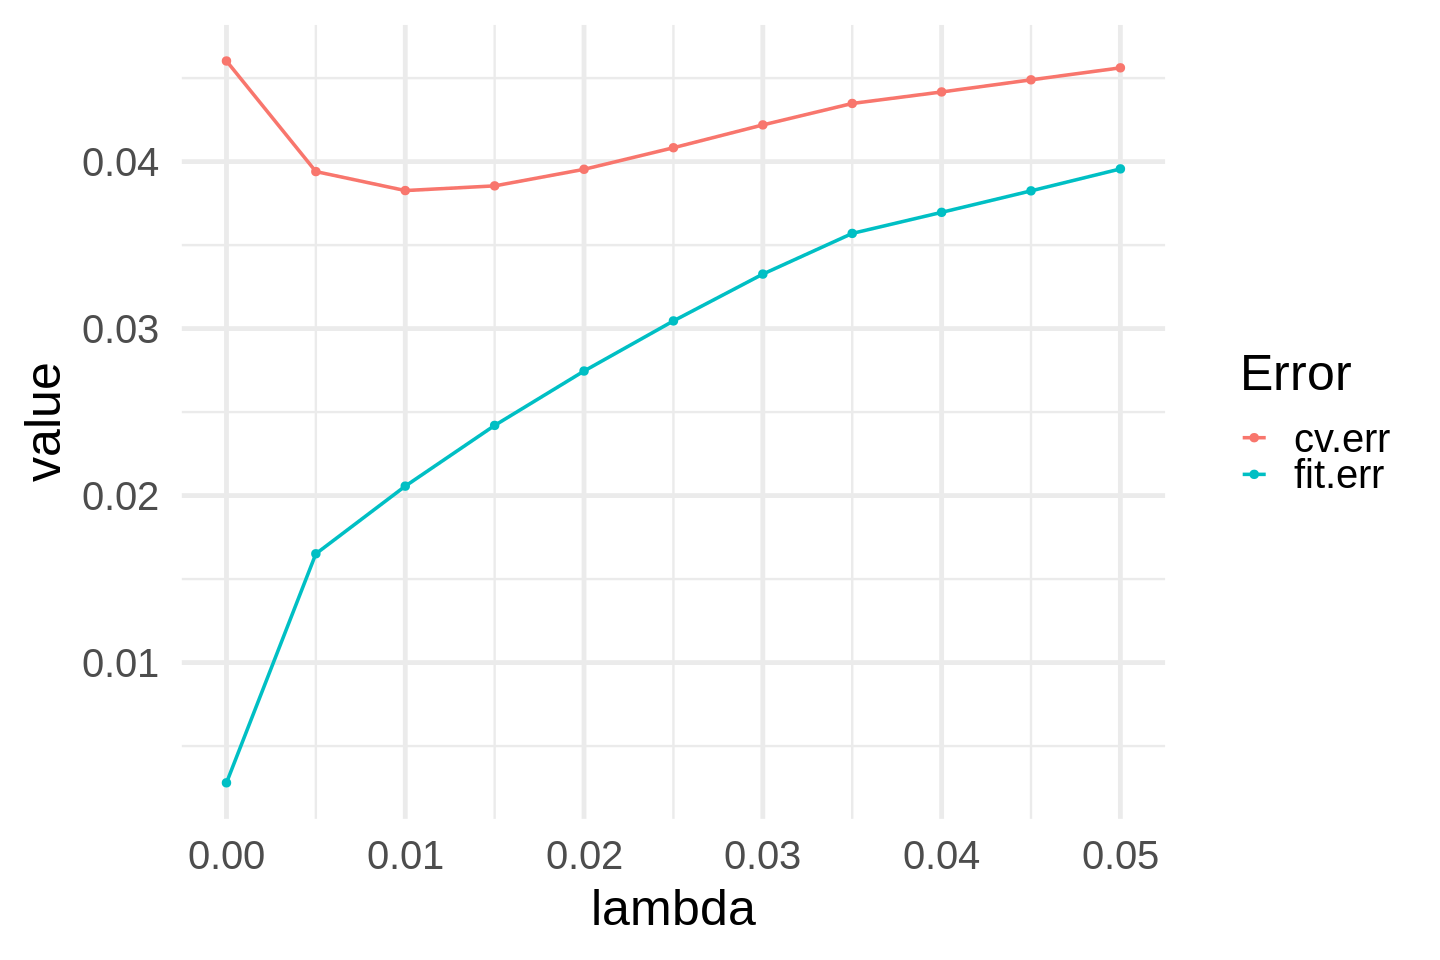

In [27]:
# Rearrange the table for plotting
data = fit.fimpute.train$meta %>% gather(Error, value, cv.err:fit.err)

options(repr.plot.width=12, repr.plot.height=8)
ggplot(aes(x = lambda, y = value, col = Error), data = data) +
    geom_line(size=1) + geom_point(size=2)

Visual investigation shows that the optimal value of the parameter is somewhere between $0.005$ and $0.015$. Therefore, we investigate that region further

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


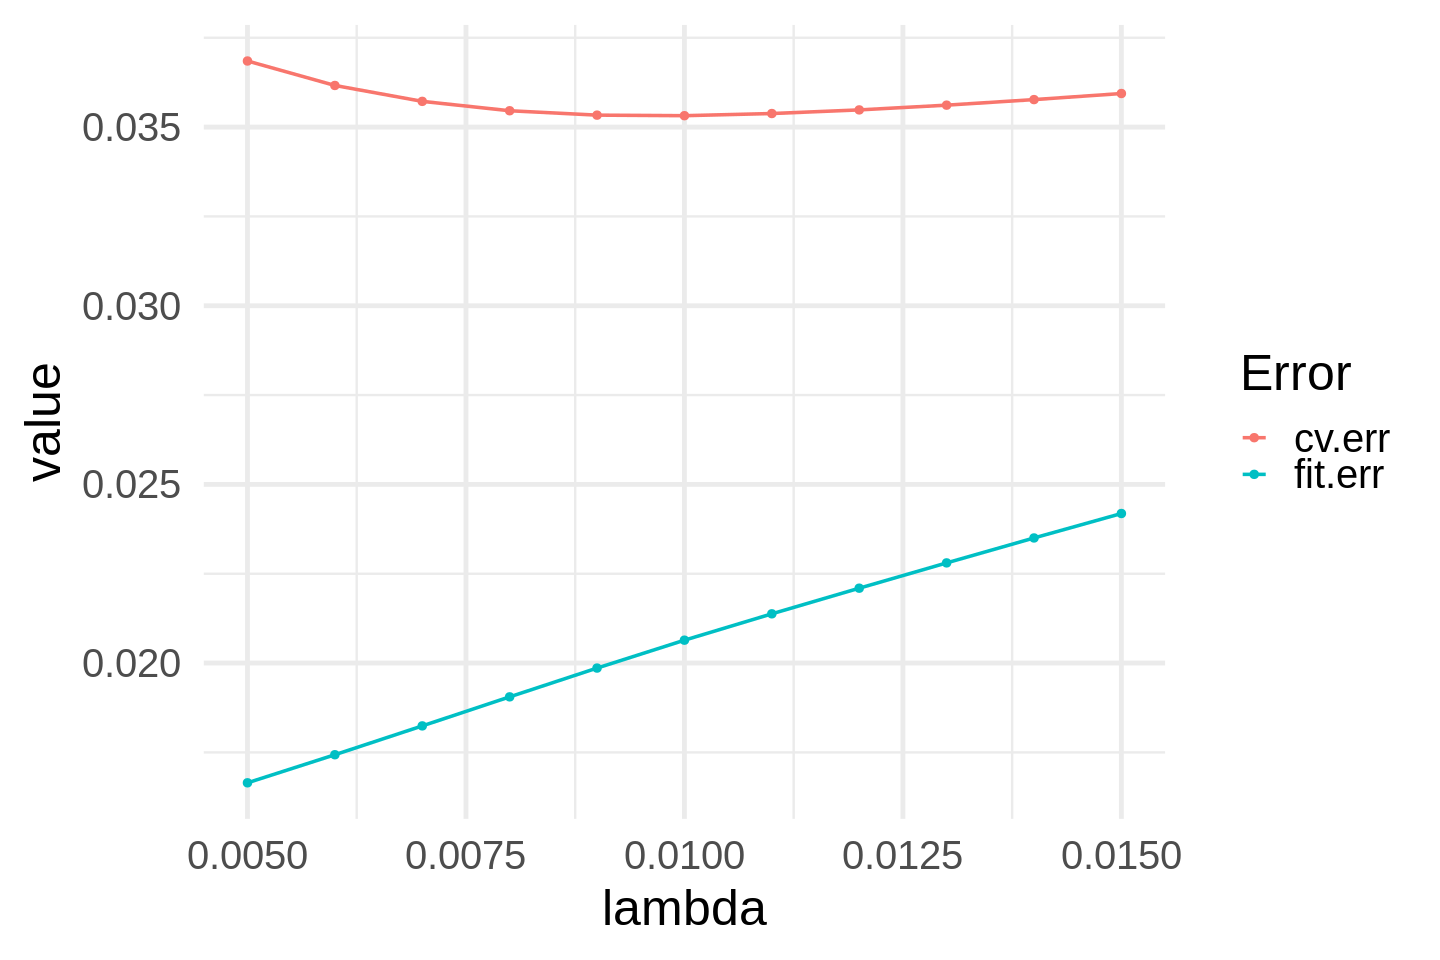

In [28]:
fit.fimpute.train = fregression(spnbmd ~ age | idnum, data = bone, d = 6, K = 3,
                                lambda=seq(0.005,0.015,by=0.001), fold=3, verbose = 0)
data = fit.fimpute.train$meta %>% gather(Error, value, cv.err:fit.err)
ggplot(aes(x = lambda, y = value, col = Error), data = data) +
    geom_line(size=1) + geom_point(size=2)

At higher granularity, we see that the cross-validation error does not change much around $\lambda=0.01$. Function `fregression` has chosen the bests lambda and refitted the model using that parameter.

In [29]:
fit.fimpute.train$lambda

[1] 0.01

## On choice of the number of basis elements $d$

One important parameter that hasn't been discussed so far is the number of basis elements. `fcomplete` uses quadratic splines by default. Let's look at the basis used in the previous model, by accessing the `basis` element. Note that the matrix of splines is orthonormalized.

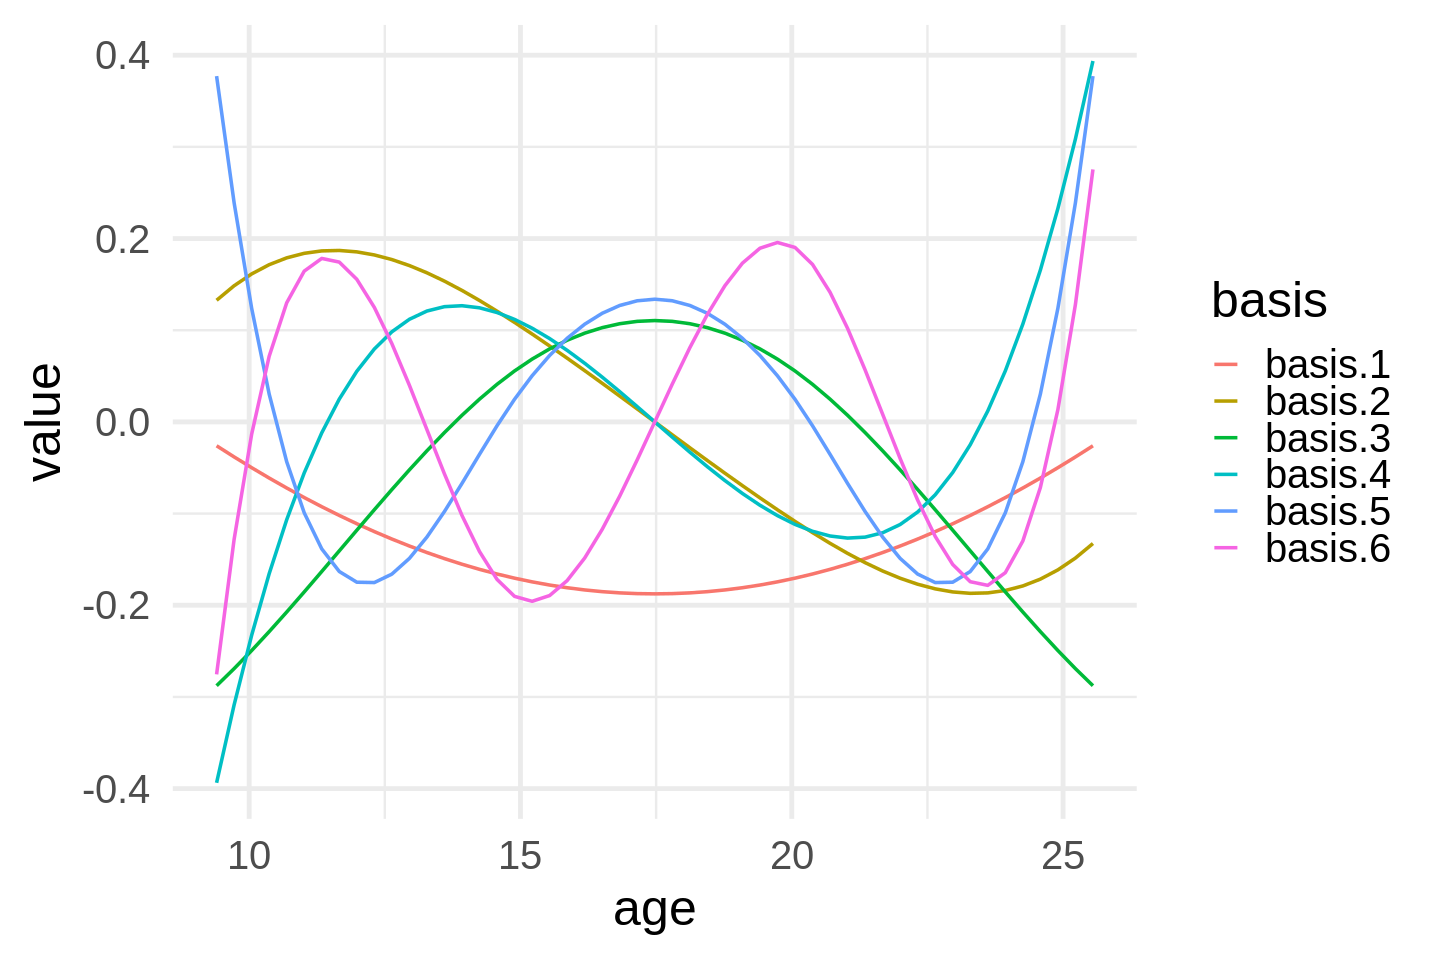

In [30]:
data = data.frame(age=fit.fimpute.train$time.grid, basis=fit.fimpute.train$basis) %>%
    gather(basis, value, basis.1:basis.6)
ggplot(aes(x = age, y = value, col = basis), data = data) +
    geom_line(size=1)

The number of splines can significantly influence performance of our method. Too large number of splines will result in overfitting (a larger mapping from latent space to splines must be learned). Too small number of splines can increase the bias. Here we present how $d=21$ 'improves' the fit (judging by r-squared), but the actuall cross-validation errors are larger.

In [31]:
fit.fimpute.train = fregression(spnbmd ~ age | idnum, data = bone, d = 21, K = 3,
                                lambda=seq(0.005,0.015,by=0.01), fold=3, verbose = 0)
print(fit.fimpute.train)

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


fcomplete fitted using the 'fimpute' method with a formula: ~spnbmdage | idnum
  Number of fitted subjects (N):	 261
  Number of evaluation timpoints:	 51
  Maximum dimension (K):		 3
  Observed to N*K ratio:		 0.6194125
  Estimated r-squared:			 0.9601313

In [9]:
fit.fimpute.train$meta

lambda,cv.K,cv.err,fit.err
<dbl>,<dbl>,<dbl>,<dbl>
0.00,3.0000000,0.05038453,0.0001094677
0.02,3.0000000,0.04225148,0.0139319775
0.04,3.0000000,0.04142148,0.0232854159
0.06,3.0000000,0.04146688,0.0302954653
0.08,2.0000000,0.04220966,0.0357596719
0.10,2.0000000,0.04307370,0.0396657455
0.12,0.3333333,0.04377777,0.0420435366
0.14,0.0000000,0.04378063,0.0420718623
0.16,0.0000000,0.04378063,0.0420718623


We see that despite high $R^2$ and very low `fit error` for each $\lambda$, we actually get worse out-of-sample predictions compared to the earlier analysis with $d=6$.

While large number of splines led to unfavorable solutions, it might be useful in scenarios where many more observations per subjects are collected.

# Other parameters

The number of basis functions $d$ and the penalty $\lambda$, described in the previous section, are the main tuning variables in the model. Here, we briefly discuss other tuning parameters of the model:

| parameter | description |
| -: | :- |
| `bins` | controls the size of the grid used for evaluation of functions. The density of the grid does not influence efficiency of the algorithm, but may influence the time performance. We adivice to keep this parameter the lowest possible without loosing much temporal information (observed points are mapped to the grid points so the distance between the points and the grid should be set small on average). |
| `maxIter` | number of itarations of the optimization in the Soft-Longitudinal-Impute algorithm (see Algorithm 1 in Kidziński, Hastie (2021)) |
| `thresh` | exit condition for *per step* improvement in the Soft-Longitudinal-Impute algorithm (see Algorithm 1 in Kidziński, Hastie (2021)) |
| `final` | variable deciding if after the choice of $K$ in cross-validation we want to get Soft-Longitudinal-Impute (`soft`) or Hard-Longitudinal-Impute (`hard`) output. For the racionale behind the two please see Section 3.5 in Kidziński, Hastie (2021). |